In [1]:
import random

import pandas as pd
import torch
from matplotlib import pyplot as plt
from torch.nn import *
from torch.optim import *

from model import LSTMModel

Read Preprocessed Dataset 

In [2]:
path = './data/knn_clean_data.csv'
df = pd.read_csv(path)
# select relevant features
moods = df[['mood', 'ID']]
# process id and mood
moods = pd.get_dummies(moods, columns=['ID'])
moods['mood'] = moods['mood'].round().astype(int)
print(moods['mood'].value_counts())

7    639
8    315
6    268
5     24
9     12
4      8
3      2
Name: mood, dtype: int64


In [3]:
# define hyper-parameters
hidden_size = 128  # 隐藏层维度
num_layers = 2  # LSTM层数
output_size = 10  # 输出维度
num_epochs = 2000  # 迭代次数
learning_rate = 1e-2  # 学习率
max_grad_norm = 10.0

seq_length = 7
batch_size = 32
step = 2
# generate dataset
ids = df['ID'].unique()
id_moods = []
for uid in ids:
    uid = 'ID_' + uid
    id_mood = moods[moods[uid] == 1]
    id_moods.append(id_mood)
# remove data that is not continuous
id_moods[0] = id_moods[0][2:]

dataset = []
for id_mood in id_moods:
    id_dataset = [id_mood[i:i + seq_length + 1] for i in range(0, len(id_mood) - seq_length, step)]
    id_dataset = [df.to_numpy() for df in id_dataset]
    dataset += id_dataset

print('dataset size:', len(dataset))
# split it into train set and test set.
random_indices = random.sample(range(len(dataset)), k=int(len(dataset) / 5))
train_set = []
test_set = []

for i in range(len(dataset)):
    if i in random_indices:
        test_set.append(dataset[i])
    else:
        train_set.append(dataset[i])
print('train set size:',len(train_set))
print('test set size:', len(test_set))

X_train = [element[:seq_length] for element in train_set]
y_train = [element[seq_length:][0][:1] for element in train_set]
X_test = [element[:seq_length] for element in test_set]
y_test = [element[seq_length:][0][:1] for element in test_set]
# convert them into Tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

dataset size: 544
train set size: 436
test set size: 108


C:\Users\china\AppData\Local\Temp\ipykernel_12796\3540192103.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:278.)
  X_train = torch.tensor(X_train, dtype=torch.float32)


In [4]:
# 定义参数
input_size = X_train.shape[-1]  # 输入维度
# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 创建模型并将其移动到设备上
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
# 定义损失函数和优化器
criterion = CrossEntropyLoss()
# optimizer = Adam(model.parameters(), lr=learning_rate)
optimizer = RMSprop(model.parameters(), lr=learning_rate)

loss_history = []
test_acc_history = []
train_acc_history = []
batch_num = len(X_train) // batch_size
# 训练模型
for epoch in range(num_epochs):
    total_loss = 0
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i + batch_size].to(device)
        targets = y_train[i:i + batch_size].to(device)
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, targets.squeeze().long())
        total_loss += loss.item()
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        # 剪枝
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
        optimizer.step()
        
    total_loss = total_loss / batch_num
    loss_history.append(total_loss)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss:.4f}')
        # 模型评估
        with torch.no_grad():
            correct = 0
            total = 0
            for i in range(0, len(X_test), batch_size):
                inputs = X_test[i:i + batch_size].to(device)
                targets = y_test[i:i + batch_size].to(device)
                targets = targets.transpose(0, 1)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(1)
                correct_matrix = (predicted == targets)
                correct += (predicted == targets).sum().item()
            print(f'Accuracy on test set: {100 * correct / total:.2f}%')
            test_acc_history.append(100 * correct / total)

            correct = 0
            total = 0
            for i in range(0, len(X_train), batch_size):
                inputs = X_train[i:i + batch_size].to(device)
                targets = y_train[i:i + batch_size].to(device)
                targets = targets.transpose(0, 1)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(1)
                correct_matrix = (predicted == targets)
                correct += (predicted == targets).sum().item()
            print(f'Accuracy on train set: {100 * correct / total:.2f}%')
            train_acc_history.append(100 * correct / total)
    

Epoch [10/2000], Loss: 1.3154
Accuracy on test set: 50.00%
Accuracy on train set: 46.10%
Epoch [20/2000], Loss: 1.2761
Accuracy on test set: 53.70%
Accuracy on train set: 50.23%
Epoch [30/2000], Loss: 1.2239
Accuracy on test set: 47.22%
Accuracy on train set: 50.00%
Epoch [40/2000], Loss: 1.1970
Accuracy on test set: 44.44%
Accuracy on train set: 52.75%
Epoch [50/2000], Loss: 1.1474
Accuracy on test set: 55.56%
Accuracy on train set: 55.73%
Epoch [60/2000], Loss: 1.0944
Accuracy on test set: 48.15%
Accuracy on train set: 55.73%
Epoch [70/2000], Loss: 1.0373
Accuracy on test set: 52.78%
Accuracy on train set: 60.55%
Epoch [80/2000], Loss: 1.0545
Accuracy on test set: 54.63%
Accuracy on train set: 55.73%
Epoch [90/2000], Loss: 1.0181
Accuracy on test set: 50.00%
Accuracy on train set: 58.49%
Epoch [100/2000], Loss: 1.0311
Accuracy on test set: 55.56%
Accuracy on train set: 59.63%
Epoch [110/2000], Loss: 1.0147
Accuracy on test set: 59.26%
Accuracy on train set: 61.01%
Epoch [120/2000], L

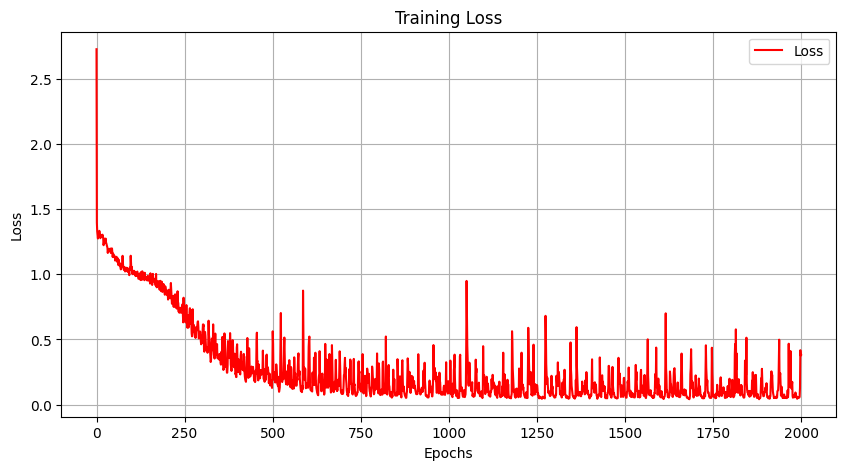

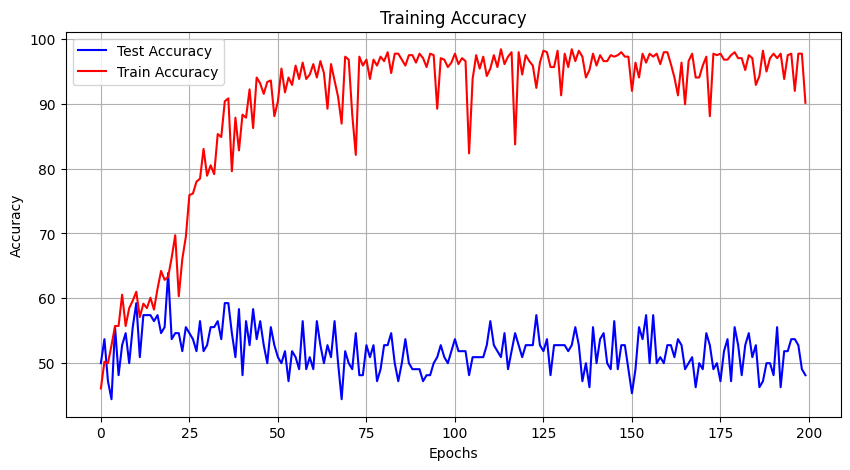

In [6]:
# visualization
plt.figure(figsize=(10, 5))
plt.plot(loss_history, 'r', label='Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 绘制准确率图像
plt.figure(figsize=(10, 5))
plt.plot(test_acc_history, 'b', label='Test Accuracy')
plt.plot(train_acc_history, 'r', label='Train Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()